<h1> <b> <div style='padding:25px;background-color:#9B2335;color:white;border-radius:4px;font-size:100%;text-align: center'>Singapore  Resale Flat Prices Prediction<br> </div></h1>

<h2> <p style="color:Khaki;"> Importing required libraries</p></h2>

In [3]:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle
from scipy.special import inv_boxcox

sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
import time
from colorama import Fore, Style
from xgboost import XGBRegressor, cv, DMatrix


color_positive = Fore.GREEN
reset_color = Style.RESET_ALL


---
title: "Model Building - Before Outlier"
author: "Santhoh Kumar"
date: last-modified
format: 
  html:
    theme: darkly
    fontsize: 1.1em
    max-width: 2800px
    fontcolor: "#ffffff"
    code-fold: true
    code-tools: true
    code-block-bg: true
    code-block-border-left: "#31BAE9"
    toc: true
    toc-depth: 4
    toc-expand: 4
    toc-location: body
    number-sections: true
    number-depth: 3
jupyter: python3
---


## <span style="color:Khaki;">Reading Transformed Dataset

In [4]:
df1=pd.read_feather('data_trans.feather')

In [5]:
df1.sample(4)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox
97070,7,Woodlands,Executive,146.0000,Maisonette,1988,380000.0000,3,3,1995,838 Woodlands St 82 Woodlands,2602.7397,92,636.0736,13.0704
48965,5,Bukit Timah,3 Room,73.0000,Improved,1974,438000.0000,3,12,2019,4 Queen'S Rd Bukit Timah,6000.0000,54,677.1059,9.7438
139684,2,Woodlands,4 Room,104.0000,Model A,1985,420000.0000,3,3,2022,337 Woodlands Ave 1 Woodlands,4038.4615,62,664.7169,11.3429
106317,11,Yishun,5 Room,121.0000,Improved,1987,275000.0000,3,3,2002,626 Yishun St 61 Yishun,2272.7273,84,551.6626,12.0891


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927465 entries, 0 to 181261
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   month                 927465 non-null  category
 1   town                  927465 non-null  category
 2   flat_type             927465 non-null  category
 3   floor_area_sqm        927465 non-null  float32 
 4   flat_model            927465 non-null  category
 5   lease_commence_date   927465 non-null  category
 6   resale_price          927465 non-null  float64 
 7   floors                927465 non-null  category
 8   floor_no              927465 non-null  int8    
 9   year                  927465 non-null  category
 10  full_address          927465 non-null  category
 11  price_per_sqm         927465 non-null  float64 
 12  remaining_lease_year  927465 non-null  category
 13  resale_price_boxcox   927465 non-null  float64 
 14  floor_area_boxcox     927465 non-null  fl

## <span style="color:Khaki;"> Encoding Categorical Features:</span> 

In [7]:
town_en = df1.groupby('town',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
town_en_list = dict(zip(town_en['town'], town_en['resale_price_boxcox'].astype(int)))
print(town_en_list)

{'Lim Chu Kang': 1, 'Queenstown': 2, 'Ang Mo Kio': 3, 'Clementi': 4, 'Geylang': 5, 'Bedok': 6, 'Bukit Batok': 7, 'Yishun': 8, 'Toa Payoh': 9, 'Jurong East': 10, 'Central Area': 11, 'Jurong West': 12, 'Kallang/Whampoa': 13, 'Woodlands': 14, 'Hougang': 15, 'Serangoon': 16, 'Marine Parade': 17, 'Bukit Merah': 18, 'Bukit Panjang': 19, 'Tampines': 20, 'Choa Chu Kang': 21, 'Sembawang': 22, 'Pasir Ris': 23, 'Bishan': 24, 'Bukit Timah': 25, 'Sengkang': 26, 'Punggol': 27}


In [8]:
df1['town_en'] = df1['town'].map(town_en_list)
df1['town_en'] = df1['town_en'].astype('int8')

year_en = df1.groupby('year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
year_en_list = dict(zip(year_en['year'], year_en['resale_price_boxcox'].astype(int)))
print(year_en_list)

df1['year_en'] = df1['year'].map(year_en_list)
df1['year_en'] = df1['year_en'].astype('int8')

In [9]:
flat_type_en = df1.groupby('flat_type',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_type_en_list = dict(zip(flat_type_en['flat_type'], flat_type_en['resale_price_boxcox'].astype(int)))
print(flat_type_en_list)

{'1 Room': 1, '2 Room': 2, '3 Room': 3, '4 Room': 4, '5 Room': 5, 'Executive': 6, 'Multi Generation': 7}


In [10]:
df1['flat_type_en'] = df1['flat_type'].map(flat_type_en_list)
df1['flat_type_en'] = df1['flat_type_en'].astype('int8')

In [11]:
flat_model_en = df1.groupby('flat_model',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_model_en_list = dict(zip(flat_model_en['flat_model'], flat_model_en['resale_price_boxcox'].astype(int)))
print(flat_model_en_list)

{'New Generation': 1, 'Standard': 2, 'Simplified': 3, 'Model A2': 4, '2-Room': 5, 'Model A': 6, 'Improved': 7, 'Improved-Maisonette': 8, 'Model A-Maisonette': 9, 'Premium Apartment': 10, 'Adjoined Flat': 11, 'Maisonette': 12, 'Apartment': 13, 'Terrace': 14, 'Multi Generation': 15, 'Premium Maisonette': 16, '3Gen': 17, 'Dbss': 18, 'Premium Apartment Loft': 19, 'Type S1': 20, 'Type S2': 21}


In [12]:
df1['flat_model_en'] = df1['flat_model'].map(flat_model_en_list)
df1['flat_model_en'] = df1['flat_model_en'].astype('int8')

lease_commence_en = df1.groupby('lease_commence_date',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
lease_commence_en_list = dict(zip(lease_commence_en['lease_commence_date'], lease_commence_en['resale_price_boxcox'].astype(int)))
print(lease_commence_en_list)

df1['lease_commence_en'] = df1['lease_commence_date'].map(lease_commence_en_list)
df1['lease_commence_en'] = df1['lease_commence_en'].astype('int8')

floors_en = df1.groupby('floors',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floors_en_list = dict(zip(floors_en['floors'], floors_en['resale_price_boxcox'].astype(int)))
print(floors_en_list)

df1['floors_en'] = df1['floors'].map(floors_en_list)
df1['floors_en'] = df1['floors_en'].astype('int8')

In [13]:
floor_no_en = df1.groupby('floor_no',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floor_no_en_list = dict(zip(floor_no_en['floor_no'], floor_no_en['resale_price_boxcox'].astype(int)))
print(floor_no_en_list)

{3: 1, 6: 2, 9: 3, 12: 4, 15: 5, 5: 6, 18: 7, 10: 8, 21: 9, 24: 10, 20: 11, 27: 12, 25: 13, 35: 14, 40: 15, 30: 16, 33: 17, 36: 18, 39: 19, 42: 20, 45: 21, 48: 22, 51: 23}


In [14]:
df1['floor_no_en'] = df1['floor_no'].map(floor_no_en_list)
df1['floor_no_en'] = df1['floor_no_en'].astype('int8')

In [15]:
remaining_lease_year_en = df1.groupby('remaining_lease_year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
remaining_lease_year_en_list = dict(zip(remaining_lease_year_en['remaining_lease_year'], remaining_lease_year_en['resale_price_boxcox'].astype(int)))
print(remaining_lease_year_en_list)

{81: 1, 82: 2, 83: 3, 80: 4, 79: 5, 84: 6, 78: 7, 85: 8, 77: 9, 76: 10, 86: 11, 75: 12, 87: 13, 88: 14, 48: 15, 74: 16, 89: 17, 49: 18, 90: 19, 47: 20, 72: 21, 73: 22, 71: 23, 45: 24, 46: 25, 70: 26, 91: 27, 44: 28, 43: 29, 50: 30, 69: 31, 92: 32, 93: 33, 68: 34, 41: 35, 42: 36, 51: 37, 67: 38, 96: 39, 52: 40, 58: 41, 66: 42, 94: 43, 59: 44, 95: 45, 57: 46, 100: 47, 65: 48, 101: 49, 53: 50, 56: 51, 64: 52, 54: 53, 55: 54, 98: 55, 60: 56, 63: 57, 62: 58, 61: 59, 97: 60, 99: 61}


In [16]:
df1['remaining_lease_year_en'] = df1['remaining_lease_year'].map(remaining_lease_year_en_list)
df1['remaining_lease_year_en'] = df1['remaining_lease_year_en'].astype('int8')

In [17]:
df1.columns

Index(['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',
       'resale_price_boxcox', 'floor_area_boxcox', 'town_en', 'flat_type_en',
       'flat_model_en', 'floor_no_en', 'remaining_lease_year_en'],
      dtype='object')

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927465 entries, 0 to 181261
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    927465 non-null  category
 1   town                     927465 non-null  category
 2   flat_type                927465 non-null  category
 3   floor_area_sqm           927465 non-null  float32 
 4   flat_model               927465 non-null  category
 5   lease_commence_date      927465 non-null  category
 6   resale_price             927465 non-null  float64 
 7   floors                   927465 non-null  category
 8   floor_no                 927465 non-null  int8    
 9   year                     927465 non-null  category
 10  full_address             927465 non-null  category
 11  price_per_sqm            927465 non-null  float64 
 12  remaining_lease_year     927465 non-null  category
 13  resale_price_boxcox      927465 non-null  float64

In [19]:
df1.sample(3)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox,town_en,flat_type_en,flat_model_en,floor_no_en,remaining_lease_year_en
191624,10,Sembawang,4 Room,91.0000,Model A,2001,215500.0000,3,6,2005,507A Wellington Circle Sembawang,2368.1319,95,495.4884,10.7165,22,4,6,2,45
9536,4,Yishun,3 Room,68.0000,New Generation,1985,160000.0000,3,9,2000,140 Yishun Ring Rd Yishun,2352.9412,84,434.5468,9.4462,8,3,1,3,6
150467,5,Yishun,4 Room,104.0000,Model A,1988,206500.0000,3,12,2004,440 Yishun Ave 11 Yishun,1985.5769,83,486.2621,11.3429,8,4,6,4,3


## <p Style="color:Khaki;"> Feature Selection:

### <p Style="color:Aqua;"> Dropping Categorical Features & Unnecessary:

In [20]:
df2 = df1.drop(columns=['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
        'resale_price',  'floor_no',
       'full_address', 'price_per_sqm', 'remaining_lease_year',],axis=1).copy()

In [21]:
df2.columns

Index(['lease_commence_date', 'floors', 'year', 'resale_price_boxcox',
       'floor_area_boxcox', 'town_en', 'flat_type_en', 'flat_model_en',
       'floor_no_en', 'remaining_lease_year_en'],
      dtype='object')

### <p Style="color:Aqua;"> Creating :

In [22]:
df2['location_specifics'] = df2['floor_area_boxcox'] *df2['town_en']
# df2['floor_area_year'] = df2['floor_area_boxcox'] / df2['remaining_lease_year_en']
df2['age']=df2['year'].astype(int) - df2['lease_commence_date'].astype(int)
df2['flat_area'] = df2['flat_type_en'] * df2['floor_area_boxcox']
df2['model_area'] = df2['flat_model_en'] * df2['floor_area_boxcox']
df2['town_mean_price'] = df2.groupby('town_en')['floor_area_boxcox'].transform('median')
df2['floor_area_age'] = df2['floor_area_boxcox'] * (2024 - df2['remaining_lease_year_en'].astype(int))
df2['floor_weightage'] = (df2['floor_no_en'] -  df2['floors'].astype(int) ) * df2['floor_area_boxcox']


In [23]:
df2.sample(3)

,lease_commence_date,floors,year,resale_price_boxcox,floor_area_boxcox,town_en,flat_type_en,flat_model_en,floor_no_en,remaining_lease_year_en,location_specifics,age,flat_area,model_area,town_mean_price,floor_area_age,floor_weightage
32084,1979,3,1992,224.8129,9.3850,6,3,1,3,11,56.3102,13,28.1551,9.3850,10.3546,18892.0707,0.0000
279622,2004,3,2009,645.5608,11.6148,15,5,7,4,43,174.2225,5,58.0742,81.3038,11.2031,23008.9877,11.6148
19965,1986,3,2012,619.5939,10.3546,8,4,3,1,22,82.8369,26,41.4185,31.0638,10.6150,20729.9416,-20.7092


### <p Style="color:Aqua;"> Correlation:

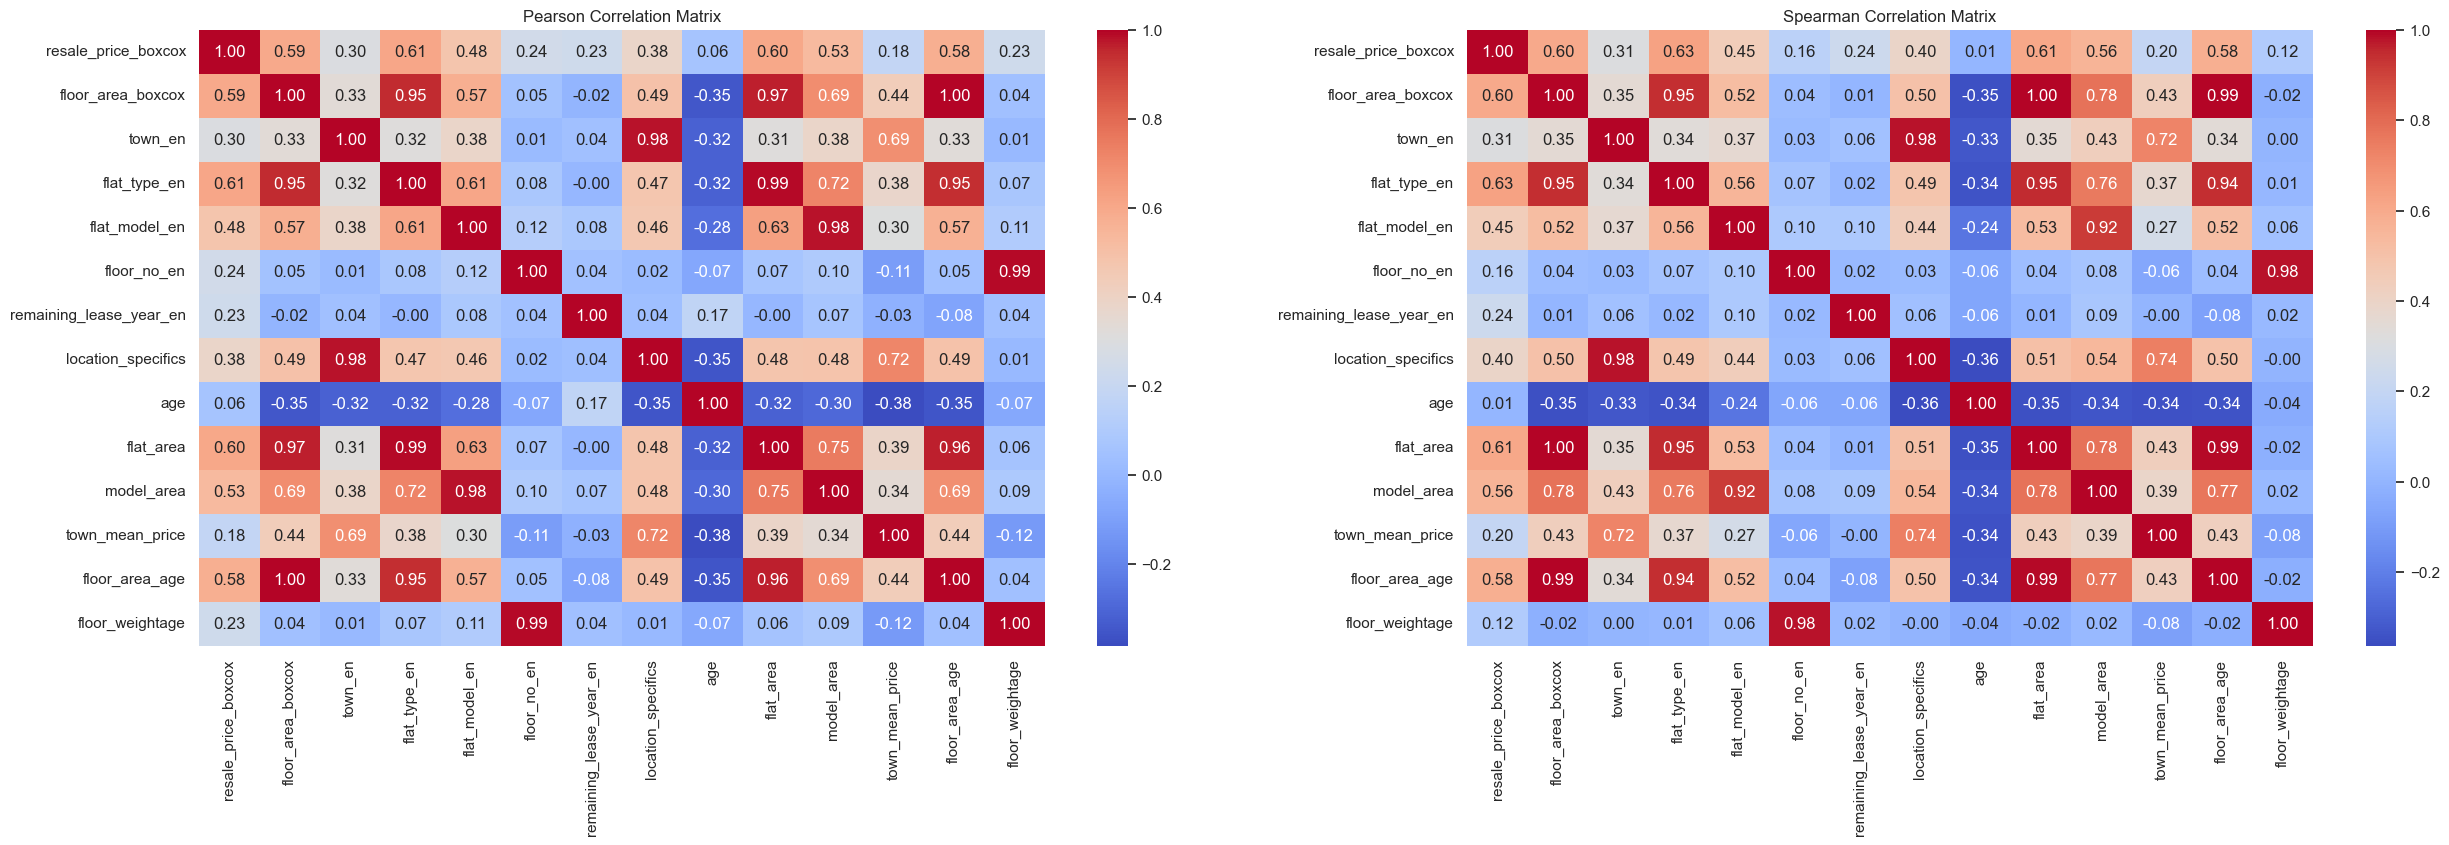

In [24]:
cor_col = df2.select_dtypes(include='number')
correlation_matrix_pear = cor_col.corr()
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
sns.heatmap(correlation_matrix_pear,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix')


cor_col = df2.select_dtypes(include='number')
correlation_matrix = cor_col.corr(method='spearman')
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [25]:
town_median = df2.groupby('town_en', observed=False)['floor_area_boxcox'].median().reset_index()
town_median_list = dict(town_median.itertuples(index=False, name=None))
town_median_list

{1: 9.323219299316406,
 2: 9.260793685913086,
 3: 9.80174732208252,
 4: 10.193489074707031,
 5: 9.80174732208252,
 6: 10.354616165161133,
 7: 10.716485977172852,
 8: 10.615007400512695,
 9: 9.446247100830078,
 10: 10.866004943847656,
 11: 9.446247100830078,
 12: 11.342947006225586,
 13: 9.859149932861328,
 14: 11.29664134979248,
 15: 11.203139305114746,
 16: 10.963958740234375,
 17: 9.916055679321289,
 18: 9.916055679321289,
 19: 11.29664134979248,
 20: 11.342947006225586,
 21: 11.525309562683105,
 22: 11.250040054321289,
 23: 12.172235488891602,
 24: 11.388961791992188,
 25: 11.342947006225586,
 26: 11.203139305114746,
 27: 10.91515064239502}

In [26]:
target_corr = df2.select_dtypes(include='number').corr(method='spearman')['resale_price_boxcox'].abs().sort_values(ascending=False)[1:]
target_corr

flat_type_en              0.6297
flat_area                 0.6065
floor_area_boxcox         0.6048
floor_area_age            0.5813
model_area                0.5608
flat_model_en             0.4460
location_specifics        0.3954
town_en                   0.3115
remaining_lease_year_en   0.2379
town_mean_price           0.2005
floor_no_en               0.1617
floor_weightage           0.1190
age                       0.0071
Name: resale_price_boxcox, dtype: float64

## <span style="color:Khaki;"> Splitting train and test Data:</span> 

In [27]:
df2.columns

Index(['lease_commence_date', 'floors', 'year', 'resale_price_boxcox',
       'floor_area_boxcox', 'town_en', 'flat_type_en', 'flat_model_en',
       'floor_no_en', 'remaining_lease_year_en', 'location_specifics', 'age',
       'flat_area', 'model_area', 'town_mean_price', 'floor_area_age',
       'floor_weightage'],
      dtype='object')

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df2.drop(['resale_price_boxcox','floor_no_en'], axis=1), df2[['resale_price_boxcox']].values.ravel(), test_size=0.2, random_state=42)

## <span style="color:Khaki;"> Scaling Data:</span> 

In [29]:
scale_reg = StandardScaler().fit(x_train)
x_train=scale_reg.transform(x_train)
x_test=scale_reg.transform(x_test)

In [30]:
x_train

array([[ 0.81874435, -0.08619591, -0.55454228, ...,  1.07694907,
         0.43998199, -0.53634996],
       [-0.40063795, -0.08619591,  1.26874707, ...,  0.62692288,
         1.02515491,  0.54738001],
       [-0.96342978, -0.08619591,  1.26874707, ..., -1.33062309,
        -0.18571624, -0.98710337],
       ...,
       [-0.7758325 , -0.08619591, -1.09080385, ..., -0.55834368,
        -0.34299351, -0.4806645 ],
       [ 1.944328  , -0.08619591,  0.62523318, ...,  0.62692288,
        -0.20412173, -0.98250331],
       [-0.40063795, -0.08619591, -1.09080385, ...,  0.29282154,
        -1.10868887, -0.43897713]])

### <p Style="color:Aqua;"> Pickle Scaling:

In [31]:
with open(r'pkls/scale_reg.pkl', 'wb') as f:
    pickle.dump(scale_reg,f)

In [32]:
print(x_train.shape, '\n\n',y_train.shape)
print(x_test.shape, '\n\n',y_test.shape)

(741972, 15) 

 (741972,)
(185493, 15) 

 (185493,)


## <span style="color:Khaki;"> Training Models:</span> 

### <p Style="color:Aqua;"> Linear Regression:

In [33]:
start_time = time.time()


LR_model = LinearRegression()

LR_model.fit(x_train,y_train)

y_preds=LR_model.predict(x_test)
y_preds_train = LR_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Coefficients - {reset_color} {LR_model.coef_} ")


print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)


Training Time: 1.11 seconds

Coefficients -  [  33.09860371    3.80890422   63.47733412  208.66256893   23.30436493
   12.75900408  -16.48793137   -4.8307175    -9.4770211    22.29088065
   -1.25515519   22.31491769  -29.82098708 -143.90409668   12.68566131] 
Test Mean Squared Error  -- 3445.20
Train Mean Squared Error  -- 3443.35

Test Root Mean Squared Error  -- 58.70
Train Root Mean Squared Error  -- 58.68

Test R2 Score  -- 0.82
Train R2 Score  -- 0.82

Test Mean Absolute Error  -- 46.50
Train Mean Absolute Error  -- 46.49

Test Median Absolute Error  -- 38.54
Train Median Absolute Error  -- 38.56

Test Explained Var  -- 0.82
Train Explained Var  -- 0.82

--------------------------------------------------


### <p Style="color:Aqua;"> Lasso:

In [165]:
start_time = time.time()


Lasso_model = Lasso(random_state=42)

Lasso_model.fit(x_train,y_train)

y_preds=Lasso_model.predict(x_test)
y_preds_train = Lasso_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 41.55 seconds

Test Mean Squared Error  -- 3449.35
Train Mean Squared Error  -- 3447.28

Test Root Mean Squared Error  -- 58.73
Train Root Mean Squared Error  -- 58.71

Test R2 Score  -- 0.82
Train R2 Score  -- 0.82

Test Mean Absolute Error  -- 46.53
Train Mean Absolute Error  -- 46.52

Test Median Absolute Error  -- 38.57
Train Median Absolute Error  -- 38.56

Test Explained Var  -- 0.82
Train Explained Var  -- 0.82

--------------------------------------------------


### <p Style="color:Aqua;"> ElasticNet:

In [34]:
start_time = time.time()


EN_model = ElasticNet(random_state=42)

EN_model.fit(x_train,y_train)

y_preds=EN_model.predict(x_test)
y_preds_train = EN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 2.75 seconds

Test Mean Squared Error  -- 4300.17
Train Mean Squared Error  -- 4279.28

Test Root Mean Squared Error  -- 65.58
Train Root Mean Squared Error  -- 65.42

Test R2 Score  -- 0.78
Train R2 Score  -- 0.78

Test Mean Absolute Error  -- 50.59
Train Mean Absolute Error  -- 50.49

Test Median Absolute Error  -- 40.27
Train Median Absolute Error  -- 40.26

Test Explained Var  -- 0.78
Train Explained Var  -- 0.78

--------------------------------------------------


### <p Style="color:Aqua;"> Decision Tree Regressor:

In [35]:
start_time = time.time()

DT_model = DecisionTreeRegressor(random_state=42,max_depth=7)

DT_model.fit(x_train,y_train)

y_preds=DT_model.predict(x_test)
y_preds_train = DT_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 4.62 seconds

Test Mean Squared Error  -- 1735.43
Train Mean Squared Error  -- 1734.53

Test Root Mean Squared Error  -- 41.66
Train Root Mean Squared Error  -- 41.65

Test R2 Score  -- 0.91
Train R2 Score  -- 0.91

Test Mean Absolute Error  -- 31.74
Train Mean Absolute Error  -- 31.76

Test Median Absolute Error  -- 25.12
Train Median Absolute Error  -- 25.30

Test Explained Var  -- 0.91
Train Explained Var  -- 0.91

--------------------------------------------------


### <p Style="color:Aqua;"> KNN Regressor:

In [ ]:
start_time = time.time()
params = {'n_neighbors' : [2,3,4,5]}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=5, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train,y_train)

y_preds=KNN_grid_model.predict(x_test)
y_preds_train = KNN_grid_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................n_neighbors=2;, score=-834.812 total time=  14.1s
[CV 2/5] END ..................n_neighbors=2;, score=-832.900 total time=  13.6s
[CV 3/5] END ..................n_neighbors=2;, score=-834.816 total time=  13.3s
[CV 4/5] END ..................n_neighbors=2;, score=-836.713 total time=  13.1s
[CV 5/5] END ..................n_neighbors=2;, score=-824.994 total time=  12.3s
[CV 1/5] END ..................n_neighbors=3;, score=-804.232 total time=  13.7s
[CV 2/5] END ..................n_neighbors=3;, score=-805.496 total time=  12.8s
[CV 3/5] END ..................n_neighbors=3;, score=-804.944 total time=  13.2s
[CV 4/5] END ..................n_neighbors=3;, score=-806.190 total time=  13.3s
[CV 5/5] END ..................n_neighbors=3;, score=-789.945 total time=  13.5s
[CV 1/5] END ..................n_neighbors=4;, score=-802.000 total time=  16.8s
[CV 2/5] END ..................n_neighbors=4;, sc

In [ ]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -801.1236158353414

KNN Best Params - {'n_neighbors': 4}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=4) 

KNN Best Index - 2 


In [ ]:
KNN_model = KNeighborsRegressor(n_neighbors=4)

KNN_model.fit(x_train,y_train)

y_preds=KNN_model.predict(x_test)
y_preds_train = KNN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 556.89 seconds

Test Mean Squared Error  -- 756.60
Train Mean Squared Error  -- 462.70

Test Root Mean Squared Error  -- 27.51
Train Root Mean Squared Error  -- 21.51

Test R2 Score  -- 0.96
Train R2 Score  -- 0.98

Test Mean Absolute Error  -- 19.30
Train Mean Absolute Error  -- 15.21

Test Median Absolute Error  -- 13.67
Train Median Absolute Error  -- 10.85

Test Explained Var  -- 0.96
Train Explained Var  -- 0.98

--------------------------------------------------


### <p Style="color:Aqua;"> Extra Tree Regressor:

In [ ]:
start_time = time.time()

ET_model = ExtraTreesRegressor(random_state=42)

ET_model.fit(x_train,y_train)

y_preds=ET_model.predict(x_test)
y_preds_train = ET_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> Random Forest Regressor:

In [ ]:
start_time = time.time()

RF_model = RandomForestRegressor(random_state=42,)

RF_model.fit(x_train,y_train)

y_preds=RF_model.predict(x_test)
y_preds_train = RF_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> XG Boost Regressor:

In [36]:
start_time = time.time()

XGB_model = XGBRegressor(random_state=42,objective='reg:squarederror', alpha=2.2,)

XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 4.52 seconds

Test Mean Squared Error  -- 476.66
Train Mean Squared Error  -- 467.82

Test Root Mean Squared Error  -- 21.83
Train Root Mean Squared Error  -- 21.63

Test R2 Score  -- 0.98
Train R2 Score  -- 0.98

Test Mean Absolute Error  -- 16.44
Train Mean Absolute Error  -- 16.29

Test Median Absolute Error  -- 12.75
Train Median Absolute Error  -- 12.65

Test Explained Var  -- 0.98
Train Explained Var  -- 0.98

--------------------------------------------------


In [39]:
cols = list(df2.columns)
cols = [col for col in cols if col not in ['resale_price_boxcox','floor_no_en']]
print(cols)

['lease_commence_date', 'floors', 'year', 'floor_area_boxcox', 'town_en', 'flat_type_en', 'flat_model_en', 'remaining_lease_year_en', 'location_specifics', 'age', 'flat_area', 'model_area', 'town_mean_price', 'floor_area_age', 'floor_weightage']


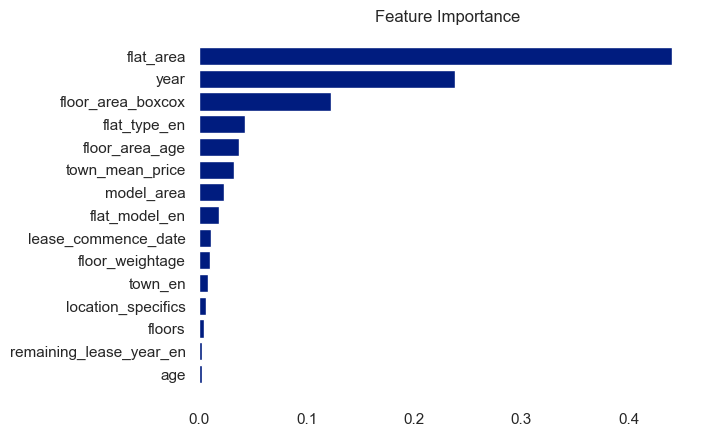

In [40]:
feature_importance = XGB_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


sorted_cols = [cols[i] for i in sorted_idx]
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, sorted_cols)
plt.title('Feature Importance')
plt.show()

## <span style="color:Khaki;"> Model Selection:</span> 

### <p style="color:Aqua"> Evaluation: </p>

- <span Style="color:Aqua"> <b>Linear Regression and Lasso - </b></span> Both have the same R2 score and similar MSEs. They show a good fit but are slightly worse compared to other models like XGBoost and Extra Trees.

 - <span Style="color:Aqua"> <b> ElasticNet - </b></span> Shows lower performance with an R2 score of 0.81, indicating underfitting.

 - <span Style="color:Aqua"> <b> Decision Tree Regressor - </b></span>  Shows good performance with an R2 score of 0.90 but is outperformed by ensemble methods.

 - <span Style="color:Aqua"> <b> KNeighbors Regressor - </b></span> Shows very high R2 scores (0.96 for test, 0.98 for train) but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> Extra Trees Regressor - </b></span> Shows excellent performance with very high R2 scores but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> XGBoost Regressor - </b></span> Shows excellent performance with very high R2 scores for both test and train. It has a smaller gap between training and testing errors compared to Extra Trees, indicating less overfitting.

#### <p Style="color:Aqua"> XGBoost Regressor is the best model in this case, with balanced performance and minimal overfitting.</p> <p Style="color:Aqua"> Random Forest & Etra Tree Regressors are also shows excellent performanance and also shows <strong> severe overfitting. </strong>

##### <p Style="color:Tomato"> I Choose XGB Regressor and also try to tune Random Forest and Extra Tree Model to reduce overfitting. </p>

## <span style="color:Khaki;"> Hyperparameter Tuning with Grid Search for XGB :</span> 

In [65]:
param_grid = {

    'learning_rate': [0.3, 0.4, 0.2],
    'max_depth': [8 ,5, 7],
    'reg_alpha' : [1,2,3]
}

In [66]:
xgb_grid = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=3, n_jobs=1,error_score='raise')
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.3, max_depth=8, reg_alpha=1;, score=-425.507 total time=   5.2s
[CV 2/3] END learning_rate=0.3, max_depth=8, reg_alpha=1;, score=-427.038 total time=   3.6s
[CV 3/3] END learning_rate=0.3, max_depth=8, reg_alpha=1;, score=-422.046 total time=   3.8s
[CV 1/3] END learning_rate=0.3, max_depth=8, reg_alpha=2;, score=-424.236 total time=   4.0s
[CV 2/3] END learning_rate=0.3, max_depth=8, reg_alpha=2;, score=-426.958 total time=   3.6s
[CV 3/3] END learning_rate=0.3, max_depth=8, reg_alpha=2;, score=-422.682 total time=   3.7s
[CV 1/3] END learning_rate=0.3, max_depth=8, reg_alpha=3;, score=-426.502 total time=   4.2s
[CV 2/3] END learning_rate=0.3, max_depth=8, reg_alpha=3;, score=-427.974 total time=   3.9s
[CV 3/3] END learning_rate=0.3, max_depth=8, reg_alpha=3;, score=-422.655 total time=   3.7s
[CV 1/3] END learning_rate=0.3, max_depth=5, reg_alpha=1;, score=-532.177 total time=   2.4s
[CV 2/3] 

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.3, 0.4, 0.2],
                         'max_depth': [8, 5, 7], 'reg_alpha': [1, 2, 3]},
             scoring='neg_mean_squared_error', verbose=3)

In [67]:
print(f"XGB Best Score - {xgb_grid.best_score_}\n\nXGB Best Params - {xgb_grid.best_params_}\n\nXGB Best Estimater - {xgb_grid.best_estimator_} \n\nXGB Best Index - {xgb_grid.best_index_} ")

XGB Best Score - -421.310557394675

XGB Best Params - {'learning_rate': 0.4, 'max_depth': 8, 'reg_alpha': 2}

XGB Best Estimater - XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 

XGB Best Index - 10 


In [41]:
start_time = time.time()

XGB_model = XGBRegressor(learning_rate=0.2, max_depth=8, n_jobs=-1,\
                           n_estimators=800,random_state=42, reg_alpha=5) 


XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time
print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 40.86 seconds

Test Mean Squared Error  -- 373.99
Train Mean Squared Error  -- 303.40

Test Root Mean Squared Error  -- 19.34
Train Root Mean Squared Error  -- 17.42

Test R2 Score  -- 0.98
Train R2 Score  -- 0.98

Test Mean Absolute Error  -- 14.31
Train Mean Absolute Error  -- 12.97

Test Median Absolute Error  -- 10.85
Train Median Absolute Error  -- 9.90

Test Explained Var  -- 0.98
Train Explained Var  -- 0.98

--------------------------------------------------


XGB_model = XGBRegressor(learning_rate=0.2, max_depth=8, n_jobs=-1,\
                           n_estimators=800,random_state=42, reg_alpha=5) 

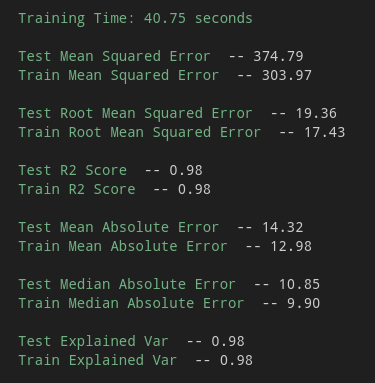

#### <span style="color:Aqua;"> We see a noticable changes in the error after tuning.</span> 

#### <span style="color:Aqua;"> I tuned few parameters manually so doing cross validations:</span> 

In [271]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
xgb_cv_score = cross_val_score(XGB_model,x_train,y_train, cv=kf)
print(f'Cross validations scores \n\n {xgb_cv_score}\n\n')
print(f'Cross validations scores mean \n\n {np.mean(xgb_cv_score)}')

Cross validations scores 

 [0.98046782 0.98060303 0.98091924 0.98075694 0.98034293 0.98016224
 0.9805305  0.98109969 0.98069942 0.98078985]


Cross validations scores mean 

 0.9806371651429707


#### <span style="color:Aqua;"> Pickling the Model:</span> 

In [273]:
import os
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/XGB_model.pkl', 'wb') as f:
    pickle.dump(XGB_model,f)

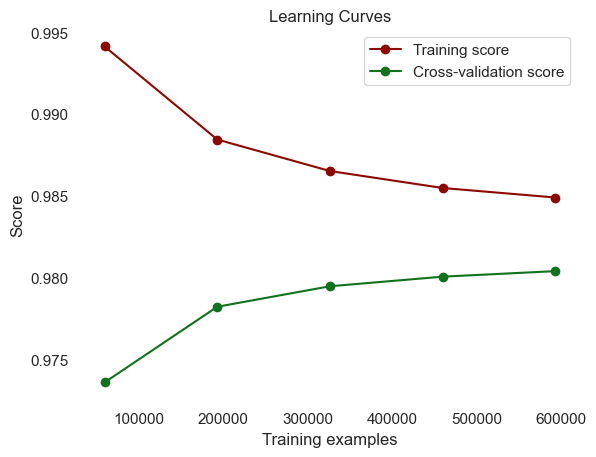

In [147]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(XGB_model, x_train, y_train, cv=5)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores.mean(axis=1), 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

#### <span style="color:Aqua;"> The learning curves initially suggest overfitting due to the large gap between training and cross-validation scores. The learning curve suggests that with more data, the model generalizes better, reducing the overfitting issue.</span> 


##


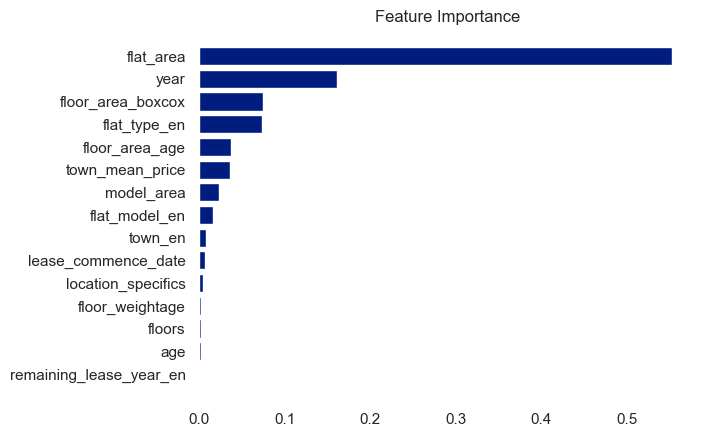

In [42]:
feature_importance = XGB_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


sorted_cols = [cols[i] for i in sorted_idx]
plt.barh(pos, feature_importance[sorted_idx])

plt.yticks(pos, sorted_cols)
plt.title('Feature Importance')
plt.show()

#### <span style="color:Khaki;"> Checking Random data points to evaluate the model:</span> 

In [43]:
index =4564

In [46]:
print(x_test[index])
print(y_test[index])

[ 0.72494571 -0.08619591  1.37599939  0.39968904  0.96004684 -0.01465908
  0.12107673 -0.76294031  0.96386113  0.47577494  0.04745541  0.11774599
  0.82221443  0.45419159 -1.0441056 ]
647.7250120367494


In [48]:
user_data = x_test[index].reshape(1, -1)
print(user_data.ndim,user_data)
prediction = XGB_model.predict(user_data)
print(f"\n\n Predicted value (Box_Cox) = {prediction}, Actual value (Box_Cox) -{y_test[index]}, \n\n Differences is {y_test[index] - prediction} ")

2 [[ 0.72494571 -0.08619591  1.37599939  0.39968904  0.96004684 -0.01465908
   0.12107673 -0.76294031  0.96386113  0.47577494  0.04745541  0.11774599
   0.82221443  0.45419159 -1.0441056 ]]


 Predicted value (Box_Cox) = [646.0643], Actual value (Box_Cox) -647.7250120367494, 

 Differences is [1.6607666] 


In [49]:
with open(r'pkls/scale_reg.pkl', 'rb') as f:
    scale_reg = pickle.load(f)

with open(r'pkls/XGB_model.pkl', 'rb') as f:
    XGB_model = pickle.load(f)

with open(r'pkls/boxcox_lambdas.pkl', 'rb') as f:
    lambda_dict = pickle.load(f)

def reverse_boxcox_transform(predicted, lambda_val):
    return inv_boxcox(predicted, lambda_val)

In [58]:
index1 = 32456

In [59]:
print(df1.iloc[index1],'\n\n')
print(print(df2.iloc[index1]))

month                                                7
town                                          Clementi
flat_type                                       5 Room
floor_area_sqm                                119.0000
flat_model                                    Improved
lease_commence_date                               1978
resale_price                               182000.0000
floors                                               3
floor_no                                            12
year                                              1992
full_address               337 Clementi Ave 2 Clementi
price_per_sqm                                1529.4118
remaining_lease_year                                85
resale_price_boxcox                           459.9386
floor_area_boxcox                              12.0050
town_en                                              4
flat_type_en                                         5
flat_model_en                                        7
floor_no_e

In [60]:
cols

['lease_commence_date',
 'floors',
 'year',
 'floor_area_boxcox',
 'town_en',
 'flat_type_en',
 'flat_model_en',
 'remaining_lease_year_en',
 'location_specifics',
 'age',
 'flat_area',
 'model_area',
 'town_mean_price',
 'floor_area_age',
 'floor_weightage']

In [61]:
data = df2.iloc[index1][cols].values.reshape(1,-1)
data_df = pd.DataFrame(data, columns=cols)
print(data_df),'\n\n'
scaled_data = scale_reg.transform(data_df)
print(scaled_data)

   lease_commence_date  floors      year  floor_area_boxcox  town_en  \
0            1978.0000  3.0000 1992.0000            12.0050   4.0000   

   flat_type_en  flat_model_en  remaining_lease_year_en  location_specifics  \
0        5.0000         7.0000                   8.0000             48.0201   

      age  flat_area  model_area  town_mean_price  floor_area_age  \
0 14.0000    60.0251     84.0351          10.1935      24202.1206   

   floor_weightage  
0          12.0050  
[[-0.96342978 -0.08619591 -1.51981311  0.92273452 -1.3131148   1.03958445
   0.41978676 -0.88496205 -1.17979527 -0.36369461  0.99392348  0.49446367
  -0.78341538  0.98838518  0.53417263]]


In [62]:
prediction = XGB_model.predict(scaled_data)
print(f"Predicted value (Box_Cox) {prediction}")
transformed_predict=reverse_boxcox_transform(prediction, lambda_dict['resale_price_lambda'])
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}")

Predicted value (Box_Cox) [482.9969]
Predicted value (Inverse Box_Cox) [203367.48]


In [63]:
actuals = df1.iloc[index1]['resale_price']
actuals

182000.0

In [64]:
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}, Actual value (without Box_Cox Transformation) -{actuals}, \n\n Differences is {actuals - transformed_predict}")

Predicted value (Inverse Box_Cox) [203367.48], Actual value (without Box_Cox Transformation) -182000.0, 

 Differences is [-21367.484]
